## Trial to use Convolutional Neural Network (with Tensorflow) to detect variogram plot that implies stationary time series

#### Based on the tutorial https://www.tensorflow.org/tutorials/images/classification

##### Since the other notebook with basic CNN tutorial takes time to execute CNN every time the Jupyterlab server is restarted, created this new notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib

In [3]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# It turned out that keras by default saves files under ~/.keras/datasets/
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

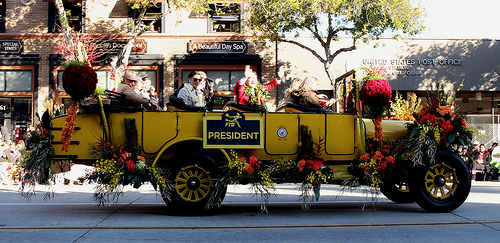

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

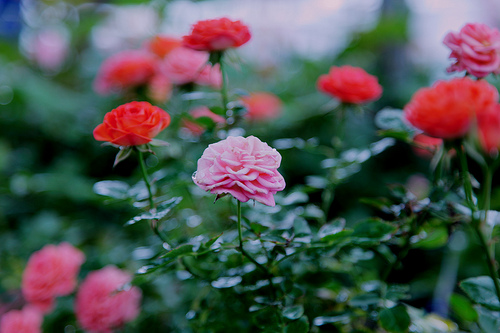

In [6]:
PIL.Image.open(str(roses[1]))

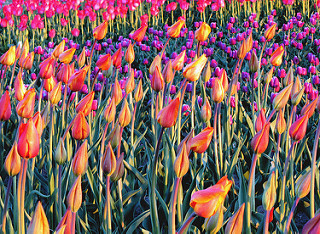

In [7]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

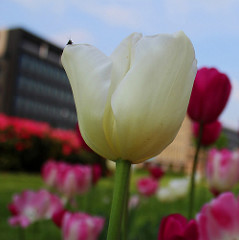

In [8]:
PIL.Image.open(str(tulips[1]))

### Load data using a Keras utility

In [9]:
batch_size = 32
img_height = 180
img_width = 180

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


2022-06-28 15:38:36.385191: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [12]:
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

#### Visualize the data

<Figure size 720x720 with 0 Axes>

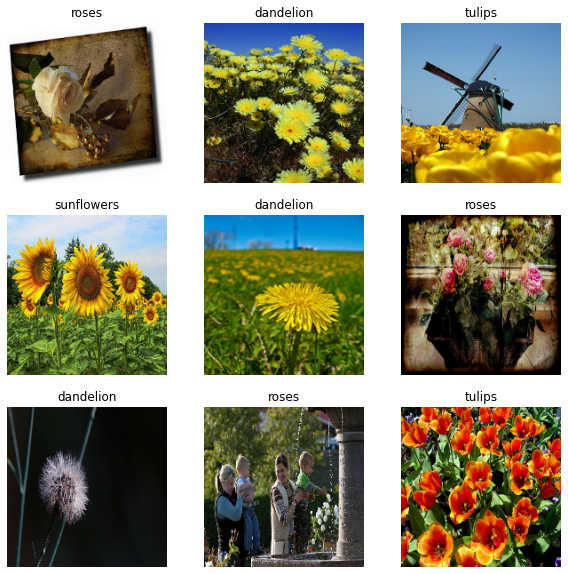

In [13]:
plt.figure(figsize=(10, 10))

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


#### Configure the dataset for performance

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Standardize the data

In [16]:
normalization_layer = layers.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
first_image

<tf.Tensor: shape=(180, 180, 3), dtype=float32, numpy=
array([[[3.47588986e-01, 5.24955213e-01, 2.17359006e-01],
        [3.17167759e-01, 4.92236763e-01, 2.03289762e-01],
        [2.31433094e-01, 4.13580269e-01, 6.40619770e-02],
        ...,
        [7.20767915e-01, 6.24173641e-01, 3.32252264e-01],
        [5.02558410e-01, 5.28621078e-01, 2.00160503e-01],
        [2.48070240e-01, 3.48515064e-01, 6.97393119e-02]],

       [[1.61140174e-01, 3.94023240e-01, 5.62091451e-03],
        [2.19389990e-01, 4.30631846e-01, 3.62962931e-02],
        [3.93703699e-01, 5.56833684e-01, 2.59055912e-01],
        ...,
        [2.70829976e-01, 3.68200660e-01, 2.80543603e-02],
        [1.80848494e-01, 2.98234850e-01, 6.36133598e-03],
        [2.14786813e-01, 3.12564254e-01, 1.13610320e-01]],

       [[1.81106284e-01, 4.18470144e-01, 5.44662355e-04],
        [2.31917232e-01, 4.52541769e-01, 1.35076232e-02],
        [1.99661121e-01, 3.93718272e-01, 1.01307202e-02],
        ...,
        [1.30586311e-01, 2.56040

In [18]:
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


### Create the model

In [19]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### Compile the model

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

#### Train the model

In [22]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 89s 956ms/step - loss: 1.4002 - accuracy: 0.4036 - val_loss: 1.1451 - val_accuracy: 0.5368
Epoch 2/10
92/92 [==============================] - 80s 866ms/step - loss: 1.0446 - accuracy: 0.5872 - val_loss: 0.9895 - val_accuracy: 0.6104
Epoch 3/10
92/92 [==============================] - 86s 933ms/step - loss: 0.8561 - accuracy: 0.6764 - val_loss: 0.9394 - val_accuracy: 0.6526
Epoch 4/10
92/92 [==============================] - 101s 1s/step - loss: 0.6557 - accuracy: 0.7561 - val_loss: 0.9328 - val_accuracy: 0.6444
Epoch 5/10
92/92 [==============================] - 97s 1s/step - loss: 0.4998 - accuracy: 0.8253 - val_loss: 1.0258 - val_accuracy: 0.6431
Epoch 6/10
92/92 [==============================] - 99s 1s/step - loss: 0.3213 - accuracy: 0.8876 - val_loss: 1.2687 - val_accuracy: 0.6362
Epoch 7/10
92/92 [==============================] - 100s 1s/step - loss: 0.1882 - accuracy: 0.9411 - val_loss: 1.4414 - val_accuracy: 0.6553
Epoch 8/1

#### Visualize training results

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

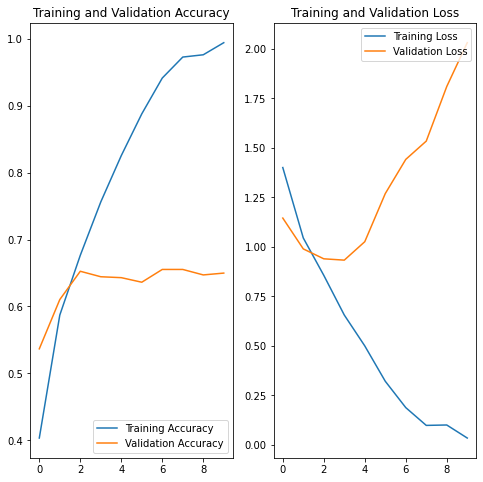

In [24]:
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Dealing with Overfitting

### Data augmentation

In [25]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

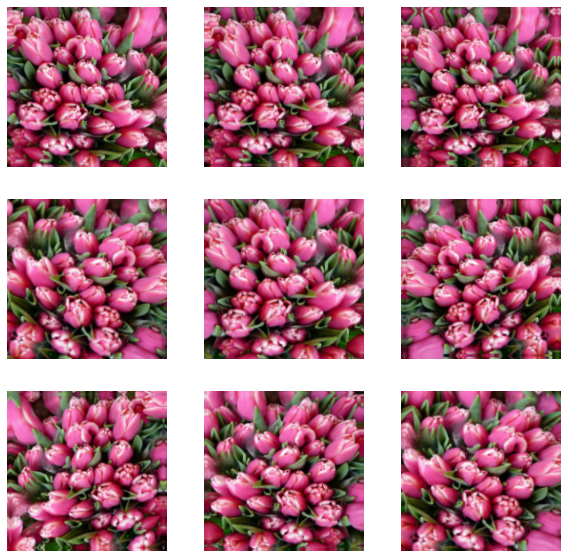

In [26]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Dropout

In [27]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### Compile and train the model

In [28]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [30]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 105s 1s/step - loss: 1.2439 - accuracy: 0.4809 - val_loss: 1.0453 - val_accuracy: 0.5790
Epoch 2/15
92/92 [==============================] - 124s 1s/step - loss: 0.9891 - accuracy: 0.6049 - val_loss: 0.9083 - val_accuracy: 0.6403
Epoch 3/15
92/92 [==============================] - 126s 1s/step - loss: 0.9277 - accuracy: 0.6369 - val_loss: 0.9105 - val_accuracy: 0.6349
Epoch 4/15
92/92 [==============================] - 121s 1s/step - loss: 0.8598 - accuracy: 0.6703 - val_loss: 0.8420 - val_accuracy: 0.6757
Epoch 5/15
92/92 [==============================] - 118s 1s/step - loss: 0.8076 - accuracy: 0.6826 - val_loss: 0.7985 - val_accuracy: 0.6921
Epoch 6/15
92/92 [==============================] - 92s 998ms/step - loss: 0.7628 - accuracy: 0.7125 - val_loss: 0.8013 - val_accuracy: 0.6853
Epoch 7/15
92/92 [==============================] - 97s 1s/step - loss: 0.7320 - accuracy: 0.7193 - val_loss: 0.7587 - val_accuracy: 0.6921
Epoch 8/15
9

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [32]:
epochs_range = range(epochs)

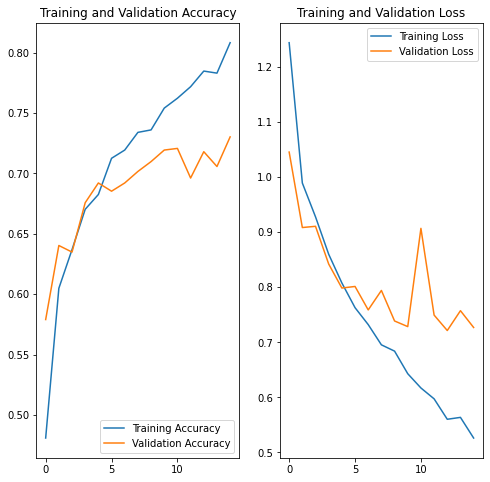

In [33]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Predict on new data

In [34]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

117948/117948 [==============================] - 0s 1us/step


In [35]:
img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)

In [36]:
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

In [37]:
predictions = model.predict(img_array)

1/1 [==============================] - 0s 234ms/step


In [38]:
score = tf.nn.softmax(predictions[0])

In [39]:
f"This image most likely belongs to {class_names[np.argmax(score)]} with a {100 * np.max(score):.2f} percent confidence."

'This image most likely belongs to sunflowers with a 98.34 percent confidence.'